In [1]:
import pandas as pd
import numpy as np
import librosa
from matplotlib import pyplot as plt
import warnings
import cv2
import dlib
import imutils
from mlxtend.image import extract_face_landmarks
import pickle

In [2]:
data_csv = pd.read_csv("processedResults/summaryTable.csv")
labels_csv = pd.read_csv("processedResults/tabulatedVotes.csv")

In [3]:
data_csv.head(5)

,Unnamed: 0,FileName,VoiceVote,VoiceLevel,FaceVote,FaceLevel,MultiModalVote,MultiModalLevel
0,1,1001_IEO_NEU_XX,N,69.1,N,92.22,N,64.78
1,2,1001_IEO_HAP_LO,N,71.67,H,57,H,57.38
2,3,1001_IEO_HAP_MD,N,67.71,H,62.62,H,56.56
3,4,1001_IEO_HAP_HI,H,63.5,H,68.25,H,73.2
4,5,1001_IEO_SAD_LO,N,73.71,N,73.5,N,74.8


In [4]:
labels_csv.head(5)

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanSadResp,medianEmoResp,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm
0,100001,0,0,0,1,10,0,1001_IEO_NEU_XX,11,0.909091,...,-1.0,87.0,66.171320,-1.000000,-1.000000,-1.0,97.894737,62.998978,-1.000,83.333333
1,100002,0,0,0,3,6,0,1001_IEO_HAP_LO,9,0.666667,...,-1.0,72.0,53.816160,-1.000000,-1.000000,-1.0,36.292735,62.577873,-1.000,53.846154
2,100003,0,0,0,4,7,0,1001_IEO_HAP_MD,11,0.636364,...,-1.0,60.0,61.874713,-1.000000,-1.000000,-1.0,55.165230,65.708703,-1.000,61.111111
3,100004,2,0,0,6,2,0,1001_IEO_HAP_HI,10,0.600000,...,-1.0,69.5,52.927309,84.420185,-1.000000,-1.0,56.542708,10.588235,-1.000,66.308140
4,100005,1,1,0,0,7,1,1001_IEO_SAD_LO,10,0.700000,...,6.0,80.0,59.486728,12.941176,94.936709,-1.0,-1.000000,69.123485,3.125,75.182073


In [5]:
A = labels_csv["A"]
D = labels_csv["D"]
F = labels_csv["F"]
H = labels_csv["H"]
N = labels_csv["N"]
S = labels_csv["S"]
labels = np.zeros((len(A), 6))
for i in range(len(A)):
    labels[i,:] = np.array([A[i], D[i], F[i], H[i], N[i], S[i]], dtype=np.float32)
    labels[i,:] /= np.sum(labels[i,:])
with open('data_pkl/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [6]:
files = data_csv["FileName"]
files_wav = "AudioMP3/" + files + ".mp3"
files_video = "VideoFlash/" + files + ".flv"

In [7]:
files_video = files_video[0:10]
files_wav = files_wav[0:10]

In [8]:
def my_resize(y, len_y):
    if(len(y) >= len_y):
        return y[0:len_y]
    else:
        return np.pad(y, [(0, len_y - len(y))], mode='constant', constant_values=0)

def mel_norm(mel):
    return 2*np.log(1 + mel) / np.log(1 + np.max(mel)) - 1

def mfcc_norm(mfcc):
    return 2*(mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc)) - 1

def get_audio_mfcc(files_wav):
    len_y = 111744 #median len (4608 + 2725632) / 2
    data_mfcc = []
    data_mel = []
    warnings.filterwarnings('ignore')
    for file in files_wav:
        y, sr = librosa.load(file, sr = None)
        y = my_resize(y, len_y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                            fmax=16e3)
        data_mfcc.append(mfcc_norm(mfcc.astype("float32")))
        data_mel.append(mel_norm(mel.astype("float32")))
    return data_mel, data_mfcc
data_mel, data_mfcc = get_audio_mfcc(files_wav)

with open('data_pkl/data_mel.pkl', 'wb') as f:
    pickle.dump(data_mel, f)

with open('data_pkl/data_mfcc.pkl', 'wb') as f:
    pickle.dump(data_mfcc, f)

In [9]:
def convert_and_trim_bb(image, rect):
	# extract the starting and ending (x, y)-coordinates of the
	# bounding box
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()
	# ensure the bounding box coordinates fall within the spatial
	# dimensions of the image
	startX = max(0, startX)
	startY = max(0, startY)
	endX = min(endX, image.shape[1])
	endY = min(endY, image.shape[0])
	# compute the width and height of the bounding box
	w = endX - startX
	h = endY - startY
	# return our bounding box coordinates
	return (startX, startY, w, h)

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

def norm_landmarks(landmarks):
	landmarks = landmarks.astype("float32").T
	landmarks[0,:] -= np.min(landmarks[0,:])
	landmarks[1,:] -= np.min(landmarks[1,:])
	landmarks[0,:] /= np.max(landmarks[0,:])
	landmarks[1,:] /= np.max(landmarks[1,:])
	return 2*landmarks - 1

	

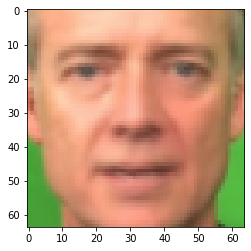

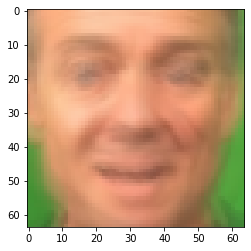

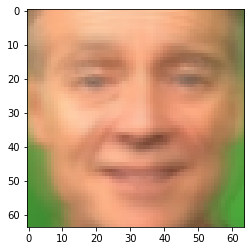

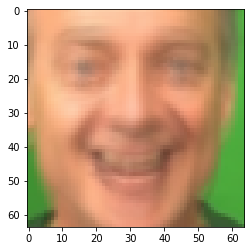

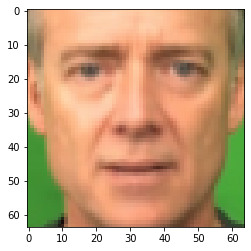

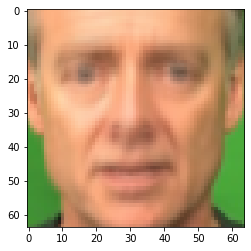

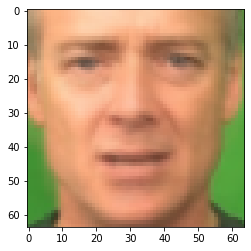

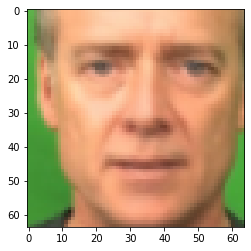

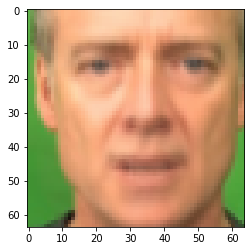

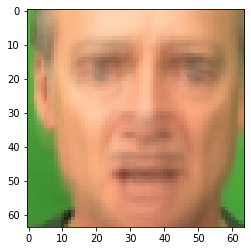

<Figure size 432x288 with 0 Axes>

In [10]:
def get_face_from_vieo(files_video):
    arr_point = []
    arr_face = []
    cnt_png = 0
    for file in files_video:
        cap = cv2.VideoCapture(file)
        im = np.zeros((64,64,3), dtype = np.float32)
        cnt = 0
        cnt2 = 0
        while(cap.isOpened()):
            ret, frame = cap.read()
            cnt2 += 1
            if ret:
                if cnt2 % 5 != 0:
                    continue
                detector = dlib.get_frontal_face_detector()
                image = imutils.resize(frame, width=600)
                rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                rects = detector(rgb, 1)
                box = [convert_and_trim_bb(rgb, r) for r in rects][0]
                img = rgb[box[1]:box[1] + box[3], box[0]:box[0] + box[2],:]
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
                im += img/255
                cnt += 1
            else:
                break
        plt.figure(1)
        plt.imshow(im/cnt)
        plt.show()
        plt.imsave('img_example/'+ str(cnt_png) + '.png', im/cnt)
        cnt_png += 1
        ln_img = im/cnt*255
        ln_img = cv2.cvtColor(ln_img.astype("uint8"), cv2.COLOR_BGR2GRAY)
        landmarks = extract_face_landmarks(ln_img.astype("uint8"))
        arr_point.append(norm_landmarks(landmarks))

        arr_face.append(2*im/cnt - 1)
        cap.release()
    return arr_face, arr_point

arr_face, arr_point = get_face_from_vieo(files_video)

with open('data_pkl/arr_face.pkl', 'wb') as f:
    pickle.dump(arr_face, f)

with open('data_pkl/arr_point.pkl', 'wb') as f:
    pickle.dump(arr_point, f)